In [117]:
import numpy as np
import pandas as pd
import csv
import os, random
import matplotlib.pyplot as plt
from skimage.io import imshow, imread, imsave
from sklearn.cluster import KMeans
from sklearn.metrics import jaccard_score
from skimage import img_as_float, img_as_ubyte
from skimage.color import gray2rgb, rgb2gray, label2rgb
from skimage.segmentation import mark_boundaries, quickshift, slic, find_boundaries, watershed, felzenszwalb
from skimage.filters import threshold_otsu, sobel
from pathlib import Path
plt.rcParams['image.cmap'] = 'gray'

## Importation aléatoire de l'image

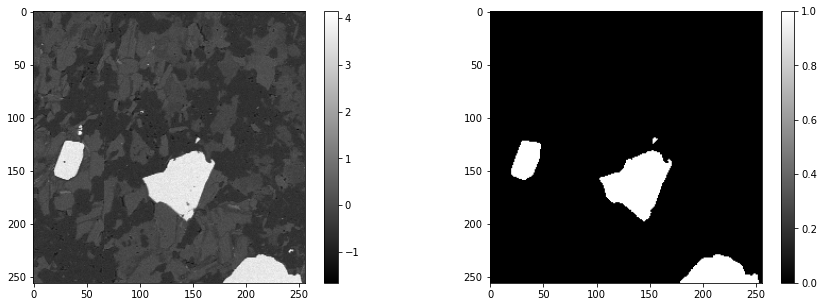

In [111]:
def RandomImg(input_dir=Path(r"C:\Users\Ange\Notebooks\test_input"), output_dir=Path(r"\Users\Ange\Notebooks\test_output")):
    img_name = random.choice(list(input_dir.glob('*.png')))
    img_input = imread(img_name)
    img_output = imread(str(img_name).replace('input', 'output'))

    while img_output.mean() == 0.0:
        img_name = random.choice(list(input_dir.glob('*.png')))
        img_input = imread(img_name)
        img_output = imread(str(img_name).replace('input', 'output'))

    return img_input, img_output//255, os.path.basename(img_name)

img_input, img_output, img_name = RandomImg()
img_input = (img_input - img_input.mean()) / img_input.std()

plt.figure(figsize=(15,5))
plt.subplot(121), plt.imshow(img_input), plt.colorbar()
plt.subplot(122), plt.imshow(img_output), plt.colorbar()
plt.show()

## K-means

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


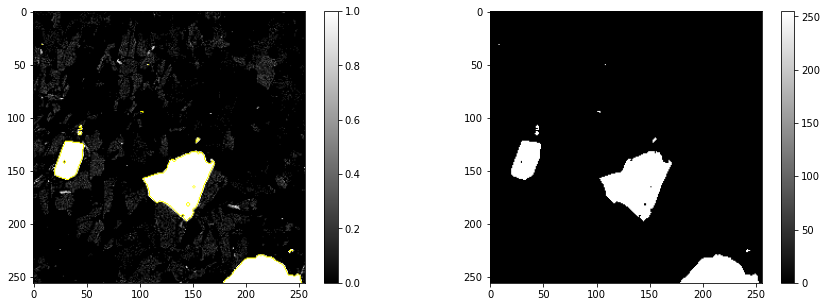

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [113]:
def algo_kmeans(img, n=2):
    img_n = img.reshape(img.shape[0]*img.shape[1],1)
    kmeans = KMeans(n_clusters=n, random_state=None).fit(img_n)
    img_seg = kmeans.labels_.reshape(img.shape)
    contours = mark_boundaries(img, img_seg, mode='inner', color=(1,1,0))
    return (img_seg*255), contours

img_seg, contours = algo_kmeans(img_input)

plt.figure(figsize=(15,5))
plt.subplot(121), plt.imshow(contours), plt.colorbar()
plt.subplot(122), plt.imshow(img_seg), plt.colorbar()
plt.show()

print(img_seg)

## Quickshift

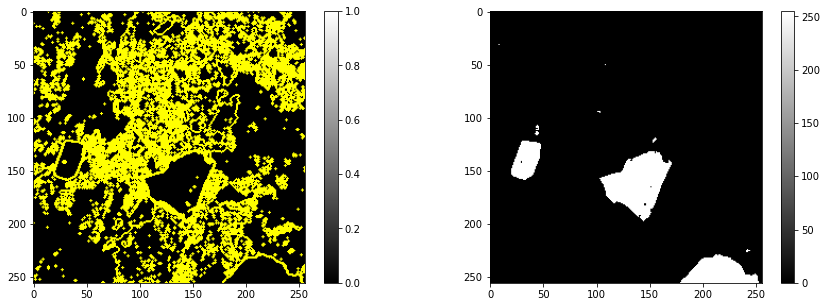

In [114]:
def algo_quickshift(img_input, kernel_size, max_dist, ratio):
    img = gray2rgb(img_input)
    segments = quickshift(img, kernel_size=kernel_size, max_dist=max_dist, ratio=ratio, convert2lab=True)
    contours = mark_boundaries(np.zeros(img.shape), segments, mode='inner', color=(1,1,0))
    img_seg = label2rgb(segments, img_input, kind='avg')
    thresh = threshold_otsu(img_seg)
    img_seg[img_seg > thresh] = 255
    img_seg[img_seg < thresh] = 0
    return img_seg, contours

img_seg, contours = algo_quickshift(img_input, 20, 10, 0.8)

plt.figure(figsize=(15,5))
plt.subplot(121), plt.imshow(contours), plt.colorbar()
plt.subplot(122), plt.imshow(img_seg), plt.colorbar()
plt.show()

## SLIC

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


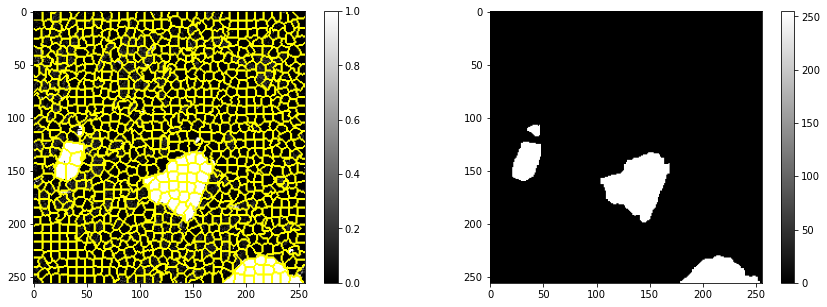

In [118]:
def algo_slic(img_input, n_segments, compactness, sigma):
    img = gray2rgb(img_input)
    segments = slic(img, n_segments=n_segments, compactness=compactness, sigma=sigma)
    contours = mark_boundaries(rgb2gray(img), segments)
    img_seg = label2rgb(segments, img_input, kind='avg')
    thresh = threshold_otsu(img_seg)
    img_seg[img_seg > thresh] = 255
    img_seg[img_seg < thresh] = 0
    return img_seg, contours

img_seg, contours = algo_slic(img_input, 1000, 20, 1)

plt.figure(figsize=(15,5))
plt.subplot(121), plt.imshow(contours), plt.colorbar()
plt.subplot(122), plt.imshow(img_seg), plt.colorbar()
plt.show()

## Watershed

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


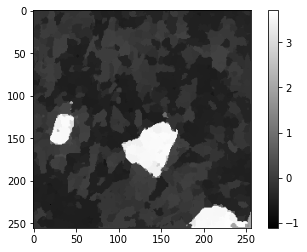

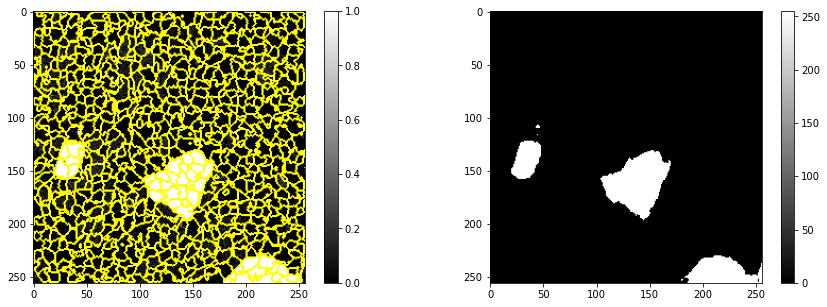

In [125]:
def algo_watershed(img_input, markers, compactness):
    gradient = sobel(img_input)
    segments = watershed(gradient, markers=markers, compactness=compactness)
    contours = mark_boundaries(img_input,  segments)
    img_seg = label2rgb(segments, img_input, kind='avg')
    plt.imshow(img_seg), plt.colorbar()
    thresh = threshold_otsu(img_seg)
    img_seg[img_seg > thresh] = 255
    img_seg[img_seg < thresh] = 0
    return img_seg, contours

img_seg, contours = algo_watershed(img_input, 1000, 0.005)

plt.figure(figsize=(15,5))
plt.subplot(121), plt.imshow(contours), plt.colorbar()
plt.subplot(122), plt.imshow(img_seg), plt.colorbar()
plt.show()

## Felzenszwalb

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


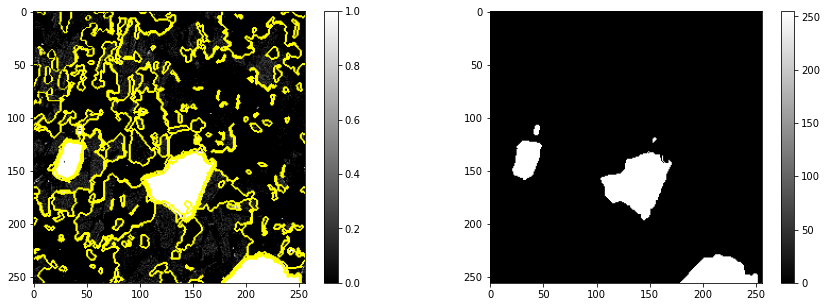

In [122]:
def algo_felzenszwalb(img_input, scale, sigma, min_size):
    segments = felzenszwalb(img_input, scale=scale, sigma=sigma, min_size=min_size)
    contours = mark_boundaries(img_input,  segments)
    img_seg = label2rgb(segments, img_input, kind='avg')
    thresh = threshold_otsu(img_seg)
    img_seg[img_seg > thresh] = 255
    img_seg[img_seg < thresh] = 0
    return img_seg, contours

img_seg, contours = algo_felzenszwalb(img_input, 1000, 0.6, 10)

plt.figure(figsize=(15,5))
plt.subplot(121), plt.imshow(contours), plt.colorbar()
plt.subplot(122), plt.imshow(img_seg), plt.colorbar()
plt.show()

## Flood / Flood fill

## Jaccard score pour les différents algorithmes

In [342]:
#Supprimer les images déjà dans le dossier
dir = '/Users/Ange/Notebooks/algo_evaluation/'
for f in os.listdir(dir):
    os.remove(os.path.join(dir, f))

#Ouvir le dossier et écrire la première ligne
with open('algo_evaluation.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    nom_algo = ['Kmeans', 'Quickshift', 'SLIC', 'Watershed', 'Felzenswalb']
    writer.writerow(['Nom image'] + nom_algo)
    
    sample_size = 10 #doit être plus petit que le nb d'iterations
    fig_sample = []
    iterations = 100
    for i in range(0,iterations):
        print(f'{int((i/iterations)*100)} %', end='\r')
        jaccard = []
        img_input, img_output, img_name = RandomImg()
        img_input = (img_input - img_input.mean()) / img_input.std() #normaliser les images
        
        fig_sample.append(img_input)
        fig_sample.append(img_output)
        
        fonctions = [
            algo_kmeans(img_input),
            algo_quickshift(img_input, 20, 10, 0.8),
            algo_slic(img_input, 1000, 20, 1),
            algo_watershed(img_input, 1000, 0.005),
            algo_felzenszwalb(img_input, 1000, 0.6, 10)
        ]

        for j, algo in enumerate(fonctions):
            img_seg = algo[0]//255
            jaccard.append(jaccard_score(img_output.flatten(), img_seg.flatten()))
            chemin = '/Users/Ange/Notebooks/algo_evaluation/'
            plt.imsave(chemin + img_name.replace('.png', f'_{nom_algo[j]}'+'.png'), img_seg)
            
            fig_sample.append(img_seg)
        
        writer.writerow([img_name[:-4]] + jaccard)
    print('100 %', end='\r')
    print('[Terminé]')


[Terminé]


## Afficher les résultats

In [344]:
data = pd.read_csv('algo_evaluation.csv')
data.head(10)
data.tail(10)

,Nom image,Kmeans,Quickshift,SLIC,Watershed,Felzenswalb
90,K389019_1479,0.970828,0.970665,0.846585,0.930995,0.918963
91,K389019_1802,0.958228,0.958412,0.760650,0.874372,0.910448
92,K389019_713,0.000000,0.003187,0.003175,0.003241,0.003556
93,K389019_448,0.019969,0.017346,0.018326,0.017233,0.843844
94,K389019_806,0.965128,0.964286,0.725709,0.907258,0.937692
95,K389005_365,0.001985,0.001985,0.002274,0.002269,0.002040
96,K389019_88,0.922727,0.922727,0.657489,0.755490,0.868571
97,K389019_1810,0.939394,0.944208,0.818795,0.856041,0.908718
98,K389019_1903,0.984843,0.984956,0.946979,0.966179,0.967255
99,K389019_904,0.976980,0.974310,0.842864,0.928380,0.920042


In [345]:
data[:].mean()

Kmeans         0.498698
Quickshift     0.536919
SLIC           0.460991
Watershed      0.517839
Felzenswalb    0.566602
dtype: float64

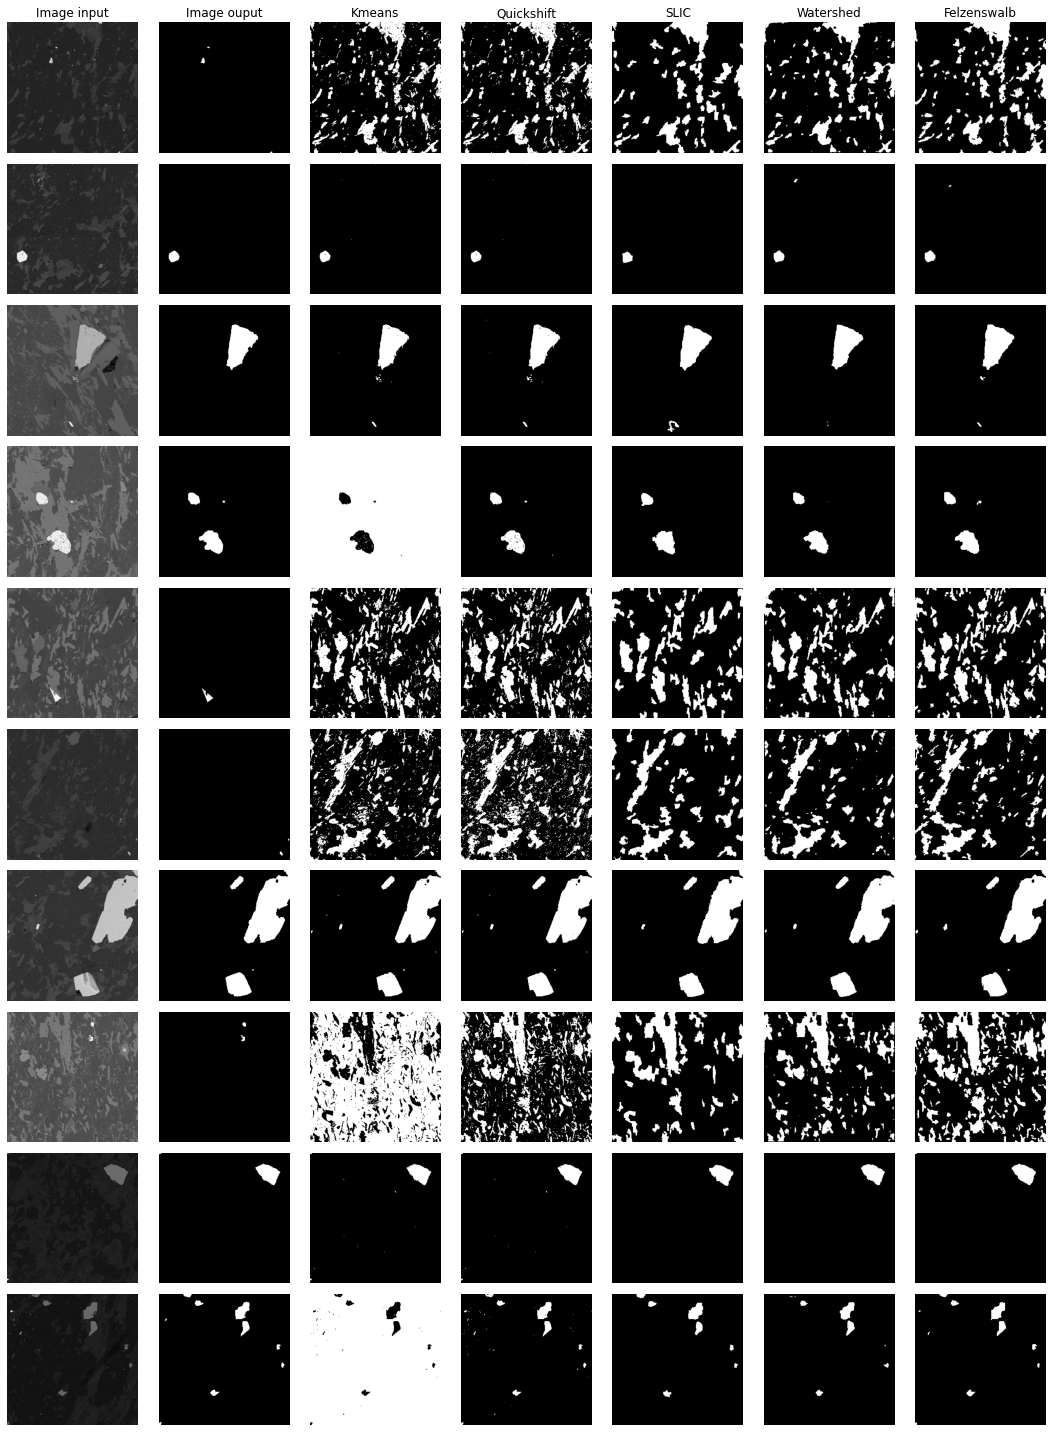

In [355]:
f, ax = plt.subplots(sample_size, 7, figsize=(15,20)) 
for i,x in enumerate(ax.flatten()):
        x.imshow(fig_sample[i])
        x.axis('off')

ax[0,0].set_title('Image input')
ax[0,1].set_title('Image ouput')
for n, nom in enumerate(nom_algo):
    ax[0,n+2].set_title(nom)

plt.tight_layout()
plt.show()